*This notebook takes care of loading the DHS and Mics data, as well as downloading the corresponding satellite images.*

In [218]:
import os

import numpy as np
import sklearn
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import copy

In [2]:
os.getcwd()

'c:\\Users\\ikhla\\OneDrive\\Bureau\\Stage\\Madagascar\\Data'

**DHS data from 5 years/periods:**

In [3]:
# Code to create dataframes out of each survey, an automated (and better) version is given just below
'''
dhs_year_survey = {'1997': 'mada_dhs_1997_assets_cleaned.csv', 
            '200809' : 'mada_dhs_200809_assets_cleaned.csv',
            '2011' : 'mada_dhs_2011_assets_cleaned.csv',
            '2013' : 'mada_dhs_2013_assets_cleaned.csv',
            '2016' : 'mada_dhs_2016_assets_cleaned.csv'
        }

# surveys as dataframes
dhs_1997 = pd.read_csv(dhs_path + dhs_year_survey['1997'], sep = ";")
dhs_1997_gps = 
dhs_200809 = pd.read_csv(dhs_path + dhs_year_survey['200809'], sep = ";")
dhs_2011 = pd.read_csv(dhs_path + dhs_year_survey['2011'], sep = ";")
dhs_2013 = pd.read_csv(dhs_path + dhs_year_survey['2013'], sep = ";")
dhs_2016 = pd.read_csv(dhs_path + dhs_year_survey['2016'], sep = ";")
'''


'\ndhs_year_survey = {\'1997\': \'mada_dhs_1997_assets_cleaned.csv\', \n            \'200809\' : \'mada_dhs_200809_assets_cleaned.csv\',\n            \'2011\' : \'mada_dhs_2011_assets_cleaned.csv\',\n            \'2013\' : \'mada_dhs_2013_assets_cleaned.csv\',\n            \'2016\' : \'mada_dhs_2016_assets_cleaned.csv\'\n        }\n\n# surveys as dataframes\ndhs_1997 = pd.read_csv(dhs_path + dhs_year_survey[\'1997\'], sep = ";")\ndhs_1997_gps = \ndhs_200809 = pd.read_csv(dhs_path + dhs_year_survey[\'200809\'], sep = ";")\ndhs_2011 = pd.read_csv(dhs_path + dhs_year_survey[\'2011\'], sep = ";")\ndhs_2013 = pd.read_csv(dhs_path + dhs_year_survey[\'2013\'], sep = ";")\ndhs_2016 = pd.read_csv(dhs_path + dhs_year_survey[\'2016\'], sep = ";")\n'

In [4]:
dhs_path = '.\\DHS\\'
years = ['1997', '200809', '2011', '2013', '2016']

dhs_surveys = []
for i in range(5):
    dhs_surveys.append(pd.read_csv(dhs_path + 'mada_dhs_' + years[i] + '_assets_cleaned.csv', sep = ";"))

### UPDATE ###

#splitting the 2008/2009 period and concatenating the resulting dfs with the the pther surveys
dhs_2008 = dhs_surveys[1].loc[dhs_surveys[1]['year']==2008]
dhs_2009 = dhs_surveys[1].loc[dhs_surveys[1]['year']==2009]

years = [1997, 2008, 2009, 2011, 2013, 2016]

dhs_surveys[1] = dhs_2008

dhs_surveys.append(dhs_2009) #adds 2009 survey at the end of list

for i in range(2,5): #repositioning the lists in increasing year order
    dhs_surveys[i], dhs_surveys[5] = dhs_surveys[5], dhs_surveys[i]


#modifying year value from 97 to 1997, would help later to automate some code
for i in range(dhs_surveys[0].shape[0]):
    dhs_surveys[0].iloc[i,4] = 1997


# For PCA sake, drop rows with NaN from each survey
for i in range(6):
    dhs_surveys[i] = dhs_surveys[i].dropna()

# Changing the type of cluster_nb to int
for i in range(6):
    dhs_surveys[i] = dhs_surveys[i].astype({'cluster_nb':int})

dhs_surveys[0]


,hhid,cluster_nb,hh_nb,sample_weight,year,urban_rural,electricity,radio,tv,fridge,motorcycle,car_truck,telephone,recode_toilet,recode_water,recode_floor,rooms_per_person
0,8516,85,16.0,1490113,1997,rural,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"0,5"
1,9424,94,24.0,1673658,1997,urban,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"0,166666667"
2,21017,210,17.0,1070160,1997,rural,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"0,333333333"
3,6611,66,11.0,1490113,1997,rural,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"0,5"
4,11817,118,17.0,1231883,1997,rural,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"0,333333333"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7172,3823,38,23.0,496466,1997,urban,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,"0,5"
7173,173 1,173,1.0,767428,1997,rural,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"0,5"
7174,161 7,161,7.0,1143847,1997,urban,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"0,25"
7175,15326,153,26.0,1080652,1997,rural,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"0,333333333"


In [136]:
#Problem encoutered below in PCA : 
# variable rooms_per_person values are strings of the form '0,5' with a comma instead of a dot
# python can't tranform it into float. Solved it by replacing comma with a dot inside the string, 
# then pythonc an transform it automatically

def comma_to_dot(df, col_id):
    # col_id : indice de la colonne qui pose problème, dans notre cas c'est rooms_per_person
    for i in range(df.shape[0]):
        if isinstance(df.iloc[i,col_id], str):
            df.iloc[i,col_id] = df.iloc[i,col_id].replace(',', '.')
    return df


In [137]:
#Applying the function on dhs, later on mics
for k in range(6):
    dhs_surveys[k] = comma_to_dot(dhs_surveys[k], 16)

**Wealth Index**

We stack all surveys from all years in one dataframe. We perform ACP after scaling the data on the the columns from 7 (electricity) to 17 (rooms_per_person)

Explained variance ratio of first component:  0.34375847928372194


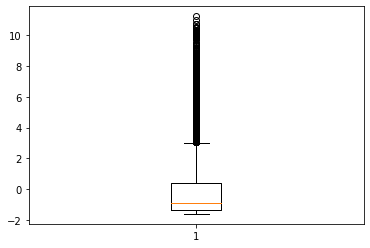

In [124]:
dhs_surveys_stacked = pd.concat(dhs_surveys, ignore_index=True, axis=0)
dhs_pca = dhs_surveys_stacked.drop(dhs_surveys_stacked.columns[0:6], axis=1, inplace=False)
dhs_var_pca = dhs_pca.columns
#PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pca1 = PCA()
dhs_C = pca1.fit(scale(dhs_surveys_stacked[dhs_var_pca])).transform(scale(dhs_surveys_stacked[dhs_var_pca]))

print('Explained variance ratio of first component: ', pca1.explained_variance_ratio_[0])
plt.boxplot(dhs_C[:,0])
plt.show()
dhs_C = pd.DataFrame(dhs_C)

In [125]:
dhs_surveys_stacked_wealth = pd.concat([dhs_surveys_stacked, dhs_C.loc[:,0]], axis=1, ignore_index=False)
dhs_surveys_stacked_wealth.rename(columns={0:'wealth_index'}, inplace=True)
dhs_surveys_stacked_wealth

,hhid,cluster_nb,hh_nb,sample_weight,year,urban_rural,electricity,radio,tv,fridge,motorcycle,car_truck,telephone,recode_toilet,recode_water,recode_floor,rooms_per_person,wealth_index
0,8516,85,16.0,1490113,1997,rural,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,-0.319047
1,9424,94,24.0,1673658,1997,urban,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166666667,-1.053303
2,21017,210,17.0,1070160,1997,rural,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333333,-1.448252
3,6611,66,11.0,1490113,1997,rural,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,-0.319047
4,11817,118,17.0,1231883,1997,rural,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333333,-0.882636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51585,590008,59,8.0,864510,2016,rural,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.333333333,1.492245
51586,3660166,366,166.0,977040,2016,rural,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,-0.232579
51587,540037,54,37.0,650080,2016,rural,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.4,0.408925
51588,2100151,210,151.0,737996,2016,urban,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.166666667,3.306048


In [126]:
# Remove unnecessary columns
dhs_wealth_stacked = dhs_surveys_stacked_wealth[['cluster_nb','year', 'urban_rural', 'wealth_index']]
dhs_wealth_stacked

,cluster_nb,year,urban_rural,wealth_index
0,85,1997,rural,-0.319047
1,94,1997,urban,-1.053303
2,210,1997,rural,-1.448252
3,66,1997,rural,-0.319047
4,118,1997,rural,-0.882636
...,...,...,...,...
51585,59,2016,rural,1.492245
51586,366,2016,rural,-0.232579
51587,54,2016,rural,0.408925
51588,210,2016,urban,3.306048


In [127]:
#changing the name of inidces to idetify each year
dhs_wealth_stacked['cluster_nb'] = dhs_wealth_stacked["year"].astype(str)+'_'+dhs_wealth_stacked["cluster_nb"].astype(str)
dhs_wealth_stacked

C:\Users\ikhla\AppData\Local\Temp\ipykernel_8368\1664777323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dhs_wealth_stacked['cluster_nb'] = dhs_wealth_stacked["year"].astype(str)+'_'+dhs_wealth_stacked["cluster_nb"].astype(str)


,cluster_nb,year,urban_rural,wealth_index
0,1997_85,1997,rural,-0.319047
1,1997_94,1997,urban,-1.053303
2,1997_210,1997,rural,-1.448252
3,1997_66,1997,rural,-0.319047
4,1997_118,1997,rural,-0.882636
...,...,...,...,...
51585,2016_59,2016,rural,1.492245
51586,2016_366,2016,rural,-0.232579
51587,2016_54,2016,rural,0.408925
51588,2016_210,2016,urban,3.306048


In [128]:
cluster_avg_wealth = dhs_wealth_stacked.groupby(['cluster_nb']).mean()
cluster_avg_wealth = cluster_avg_wealth.reset_index(level=0)
cluster_avg_wealth

,cluster_nb,year,wealth_index
0,1997_1,1997.0,0.334940
1,1997_10,1997.0,0.229033
2,1997_100,1997.0,-0.721156
3,1997_101,1997.0,-0.611641
4,1997_102,1997.0,-1.171254
...,...,...,...
1752,2016_94,2016.0,-0.499630
1753,2016_95,2016.0,-0.957804
1754,2016_96,2016.0,-0.690677
1755,2016_97,2016.0,-1.012334


In [129]:
# Averaging for each cluster
'''
dhs_wealth = [] 
for i in range(6):
    dhs_wealth.append(dhs_wealth_stacked.loc[dhs_surveys_stacked_wealth['year']==years[i]])
dhs_cluster_wealth = []
for i in range(6):
    dhs_cluster_wealth.append(dhs_wealth[i].groupby(['cluster_nb']).mean())
dhs_cluster_wealth[5]
'''

"\ndhs_wealth = [] \nfor i in range(6):\n    dhs_wealth.append(dhs_wealth_stacked.loc[dhs_surveys_stacked_wealth['year']==years[i]])\ndhs_cluster_wealth = []\nfor i in range(6):\n    dhs_cluster_wealth.append(dhs_wealth[i].groupby(['cluster_nb']).mean())\ndhs_cluster_wealth[5]\n"

**GPS Data**

In [133]:
years_corr = ['32', '53', '53', '61', '6A', '71']
# the previous line of code gives the number used in the DHS_gps data names corresponding to the year at the same index
# this helps automate access to the SHP files

dhs_gps = []
for i in range(6):
    dhs_gps_path = '.\\DHS\\dhs_gps\\' + str(years[i]) +'\\'
    dhs_gps.append(gpd.read_file(dhs_gps_path + 'MDGE'+ years_corr[i] + 'FL.shp'))


In [134]:
dhs_gps[0].head()

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,MD199700000001,MD,1997.0,1.0,MA,NULL,NULL,NULL,NULL,1.0,...,1.0,antananarivo,GPS,U,-18.920098,47.513320,9999.0,1290.0,WGS84,POINT (47.51332 -18.92010)
1,MD199700000002,MD,1997.0,2.0,MA,NULL,NULL,NULL,NULL,1.0,...,1.0,antananarivo,GPS,U,-18.902765,47.509398,9999.0,1289.0,WGS84,POINT (47.50940 -18.90276)
2,MD199700000003,MD,1997.0,3.0,MA,NULL,NULL,NULL,NULL,1.0,...,1.0,antananarivo,GPS,U,-18.903288,47.501412,9999.0,1290.0,WGS84,POINT (47.50141 -18.90329)
3,MD199700000004,MD,1997.0,4.0,MA,NULL,NULL,NULL,NULL,1.0,...,1.0,antananarivo,GPS,U,-18.890959,47.517201,9999.0,1297.0,WGS84,POINT (47.51720 -18.89096)
4,MD199700000005,MD,1997.0,5.0,MA,NULL,NULL,NULL,NULL,1.0,...,1.0,antananarivo,GPS,U,-18.881668,47.547186,9999.0,1334.0,WGS84,POINT (47.54719 -18.88167)


In [47]:
dhs_gps[1].equals(dhs_gps[2])

True

In [59]:
# the gps df from 2008 is the exactly equal to the one from 2009, no need to duplicate
del dhs_gps[2]

In [60]:
# remove unnecessary columns, converting both DHSCLUST and DHSYEAR to int, and changing some columns names
for i in range(5):
    dhs_gps[i].loc[:,'DHSCLUST'] = dhs_gps[i]['DHSCLUST'].astype(int)
    dhs_gps[i].rename(columns = {'DHSCLUST':'cluster_nb', 'DHSYEAR' : 'year', 'LATNUM' : 'lat', 'LONGNUM' : 'lon'}, inplace=True)
    dhs_gps[i] = dhs_gps[i][['cluster_nb','lat','lon','year']]
    dhs_gps[i]['year'] = dhs_gps[i]['year'].astype(int)
    dhs_gps[i]['cluster_nb'] = dhs_gps[i]['year'].astype(str) + '_' + dhs_gps[i]['cluster_nb'].astype(str)
    
dhs_gps[0]

,cluster_nb,lat,lon,year
0,1997_1,-18.920098,47.513320,1997
1,1997_2,-18.902765,47.509398,1997
2,1997_3,-18.903288,47.501412,1997
3,1997_4,-18.890959,47.517201,1997
4,1997_5,-18.881668,47.547186,1997
...,...,...,...,...
264,1997_266,-12.922970,49.017463,1997
265,1997_267,-13.076064,48.976719,1997
266,1997_268,-13.258973,48.965028,1997
267,1997_269,-13.745700,48.361942,1997


In [63]:
# stack all toghether
dhs_gps_stacked = pd.concat(dhs_gps, ignore_index=True, axis=0)
dhs_gps_stacked

,cluster_nb,lat,lon,year
0,1997_1,-18.920098,47.513320,1997
1,1997_2,-18.902765,47.509398,1997
2,1997_3,-18.903288,47.501412,1997
3,1997_4,-18.890959,47.517201,1997
4,1997_5,-18.881668,47.547186,1997
...,...,...,...,...
1757,2016_371,-14.547086,49.738813,2016
1758,2016_372,-13.697883,49.958903,2016
1759,2016_373,-13.728606,49.943289,2016
1760,2016_374,-13.882569,49.810846,2016


In [326]:
#merge the two dataframes based on the cluster_nb (and year)
dhs_merged = pd.concat([dhs_gps_stacked, cluster_avg_wealth], axis=1, join="inner")
dhs_merged = dhs_merged.loc[:,~dhs_merged.columns.duplicated()]
dhs_merged

,cluster_nb,lat,lon,year,wealth_index
0,1997_1,-18.920098,47.513320,1997,0.334940
1,1997_2,-18.902765,47.509398,1997,0.229033
2,1997_3,-18.903288,47.501412,1997,-0.721156
3,1997_4,-18.890959,47.517201,1997,-0.611641
4,1997_5,-18.881668,47.547186,1997,-1.171254
...,...,...,...,...,...
1752,2016_365,-14.319999,50.094016,2016,-0.499630
1753,2016_366,-14.488389,50.068242,2016,-0.957804
1754,2016_367,-14.487397,49.910966,2016,-0.690677
1755,2016_369,-14.659461,49.633250,2016,-1.012334


In [330]:
dhs_merged.to_csv('dhs_merged.csv', index=False)

**Satellite images extraction**

In [118]:
# The input we provide to export satellite images is a dataframe containing columns ['lat', 'lon', 'country=Madagascar', 'year'].

export_satellite_df = dhs_gps[0][['LATNUM', 'LONGNUM', 'DHSYEAR']] #selecting variables of interest from dhs_gps 1997
for i in range(1,6): #adding the following years
    export_satellite_df = pd.concat([export_satellite_df, (dhs_gps[i][['LATNUM', 'LONGNUM', 'DHSYEAR']])], axis=0)

# Adding the country column
country = pd.Series(['Madagascar']).repeat(export_satellite_df.shape[0])
country = country.tolist()
export_satellite_df['country'] = country

# Swapping the last two columns to respect the input order
export_satellite_df = export_satellite_df[['LATNUM', 'LONGNUM', 'country', 'DHSYEAR']]

export_satellite_df

# Converting the year to int to match the expected input and renaming it
export_satellite_df = export_satellite_df.astype({"DHSYEAR": int}, errors='raise') 
export_satellite_df.rename(columns = {'DHSYEAR':'year'}, inplace = True)

# Renaming the longitude and latitude columns
export_satellite_df.rename(columns = {'LATNUM':'lat', 'LONGNUM':'lon'}, inplace = True)
export_satellite_df

#exporting the dataframe to CSV:
export_satellite_df.to_csv('dhs_df.csv') # relative position

export_satellite_df


,lat,lon,country,year
0,-18.920098,47.513320,Madagascar,1997
1,-18.902765,47.509398,Madagascar,1997
2,-18.903288,47.501412,Madagascar,1997
3,-18.890959,47.517201,Madagascar,1997
4,-18.881668,47.547186,Madagascar,1997
...,...,...,...,...
353,-14.547086,49.738813,Madagascar,2016
354,-13.697883,49.958903,Madagascar,2016
355,-13.728606,49.943289,Madagascar,2016
356,-13.882569,49.810846,Madagascar,2016


**MICS data from 2018:**

In [191]:
mics_path = '.\\mics\\2018\\'

mics = pd.read_csv(mics_path + 'mada_mics_2018_assets_cleaned.csv', sep = ";")
mics_gps = pd.read_csv(mics_path + 'MICS_cluster_coord_2018.csv', sep = ";")

# Splitting the one column df 'mics_gps' based on comma. This cerate a dataframe. 
# Then adding those created columns to the original dataframe and naming them at the same time.
# The name given to the first column which corresponds to the cluster id of each household is the same as the one in the mic df:
# This is useful for joining the 2 dfs.

mics_gps[['cluster_nb', 'Longitude', 'Latitude']] = mics_gps[mics_gps.columns[0]].str.split(',', expand=True)

#deleting the first column which is no longer useful for us
mics_gps = mics_gps.drop(columns=mics_gps.columns[0])
mics_gps


,cluster_nb,Longitude,Latitude
0,1,47.50284713,-18.9035981
1,2,47.51456889,-18.90422764
2,3,47.50846729,-18.90744
3,4,47.5126883,-18.91407082
4,5,47.53946856,-18.91736051
...,...,...,...
795,796,50.18558332,-14.79203396
796,797,49.8532009,-15.01243963
797,798,50.27867778,-14.997505
798,799,50.14685049,-15.18662498


In [192]:
mics = mics.dropna()
mics.reset_index(drop=True, inplace=True)

In [194]:
mics = comma_to_dot(mics, 5)


In [195]:
mics

,hhweight,cluster_nb,hh_nb,year,urban_rural,rooms_per_person,telephone,radio,electricity,tv,fridge,motorcycle,car_truck,recode_floor,recode_water,recode_toilet
0,"1,437961621",1,1,2018,urban,0.2,0.0,1.0,1,1,0,1,0.0,0,1.0,1.0
1,"1,437961621",1,2,2018,urban,0.25,0.0,1.0,1,1,0,0,0.0,1,1.0,1.0
2,"1,437961621",1,3,2018,urban,0.5,0.0,0.0,1,1,1,0,0.0,1,1.0,1.0
3,"1,437961621",1,9,2018,urban,0.2,0.0,0.0,0,0,0,0,0.0,0,1.0,4.0
4,"1,437961621",1,10,2018,urban,0.333333333,0.0,0.0,1,1,0,0,0.0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17808,"0,355325924",800,22,2018,rural,0.166666667,0.0,0.0,0,0,0,0,0.0,0,0.0,4.0
17809,"0,355325924",800,23,2018,rural,0.5,0.0,1.0,0,0,0,0,0.0,0,0.0,4.0
17810,"0,355325924",800,24,2018,rural,0.5,0.0,0.0,0,0,0,0,0.0,0,0.0,4.0
17811,"0,355325924",800,25,2018,rural,0.2,0.0,1.0,1,0,0,0,0.0,0,0.0,4.0


**Whealth index : PCA**

Explained variance ratio of first component:  0.6889835300283688


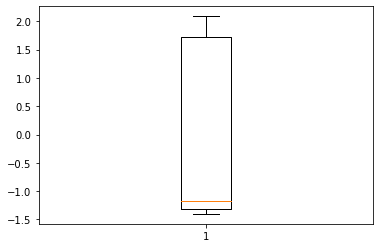

,0,1,2,3,4,5,6,7,8,9
0,1.956516,0.651591,-0.236950,-0.120860,0.821822,0.563121,0.522347,-0.542201,-0.027230,0.031154
1,2.027848,1.028881,0.038648,0.067184,-0.006080,0.154925,-0.338417,-0.160871,-0.005357,-0.017820
2,1.957089,0.720354,0.890421,0.453882,0.166870,0.458849,-0.076514,0.683961,-0.298160,0.167658
3,-1.279129,-0.012039,0.592611,-0.595142,0.249036,0.014328,0.015485,-0.004335,-0.005205,-0.002524
4,1.932318,0.632280,0.871849,0.412546,0.133763,0.169818,-0.322046,-0.166770,-0.004830,-0.019076
...,...,...,...,...,...,...,...,...,...,...
17808,-1.402101,-0.414135,0.112658,0.144281,0.052696,0.096930,-0.010160,0.003045,-0.002362,-0.000989
17809,-1.306571,-0.017534,-0.720543,-0.201081,-0.087147,0.082038,-0.026532,0.008944,-0.002889,0.000267
17810,-1.402101,-0.414135,0.112658,0.144281,0.052696,0.096930,-0.010160,0.003045,-0.002362,-0.000989
17811,-1.192593,0.489474,-0.742971,0.272852,0.435997,-0.391886,0.042133,0.051559,-0.005165,-0.003873


In [196]:
mics_pca = mics.drop(mics.columns[0:6], axis=1, inplace=False)
mics_var_pca = mics_pca.columns
#PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pca2 = PCA()
mics_C = pca2.fit(mics[mics_var_pca]).transform(mics[mics_var_pca])

print('Explained variance ratio of first component: ', pca2.explained_variance_ratio_[0])
plt.boxplot(mics_C[:,0])
plt.show()
mics_C = pd.DataFrame(mics_C)
mics_C

In [164]:
mics

,hhweight,cluster_nb,hh_nb,year,urban_rural,rooms_per_person,telephone,radio,electricity,tv,fridge,motorcycle,car_truck,recode_floor,recode_water,recode_toilet
0,"1,437961621",1,1,2018,urban,0.2,0.0,1.0,1,1,0,1,0.0,0,1.0,1.0
1,"1,437961621",1,2,2018,urban,0.25,0.0,1.0,1,1,0,0,0.0,1,1.0,1.0
2,"1,437961621",1,3,2018,urban,0.5,0.0,0.0,1,1,1,0,0.0,1,1.0,1.0
3,"1,437961621",1,9,2018,urban,0.2,0.0,0.0,0,0,0,0,0.0,0,1.0,4.0
4,"1,437961621",1,10,2018,urban,0.333333333,0.0,0.0,1,1,0,0,0.0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17865,"0,355325924",800,22,2018,rural,0.166666667,0.0,0.0,0,0,0,0,0.0,0,0.0,4.0
17866,"0,355325924",800,23,2018,rural,0.5,0.0,1.0,0,0,0,0,0.0,0,0.0,4.0
17867,"0,355325924",800,24,2018,rural,0.5,0.0,0.0,0,0,0,0,0.0,0,0.0,4.0
17868,"0,355325924",800,25,2018,rural,0.2,0.0,1.0,1,0,0,0,0.0,0,0.0,4.0


In [197]:
mics_wealth = pd.concat([mics, mics_C.loc[:,0]], axis=1, ignore_index=False)
mics_wealth.rename(columns={0:'wealth_index'}, inplace=True)
mics_wealth

,hhweight,cluster_nb,hh_nb,year,urban_rural,rooms_per_person,telephone,radio,electricity,tv,fridge,motorcycle,car_truck,recode_floor,recode_water,recode_toilet,wealth_index
0,"1,437961621",1,1,2018,urban,0.2,0.0,1.0,1,1,0,1,0.0,0,1.0,1.0,1.956516
1,"1,437961621",1,2,2018,urban,0.25,0.0,1.0,1,1,0,0,0.0,1,1.0,1.0,2.027848
2,"1,437961621",1,3,2018,urban,0.5,0.0,0.0,1,1,1,0,0.0,1,1.0,1.0,1.957089
3,"1,437961621",1,9,2018,urban,0.2,0.0,0.0,0,0,0,0,0.0,0,1.0,4.0,-1.279129
4,"1,437961621",1,10,2018,urban,0.333333333,0.0,0.0,1,1,0,0,0.0,1,1.0,1.0,1.932318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17808,"0,355325924",800,22,2018,rural,0.166666667,0.0,0.0,0,0,0,0,0.0,0,0.0,4.0,-1.402101
17809,"0,355325924",800,23,2018,rural,0.5,0.0,1.0,0,0,0,0,0.0,0,0.0,4.0,-1.306571
17810,"0,355325924",800,24,2018,rural,0.5,0.0,0.0,0,0,0,0,0.0,0,0.0,4.0,-1.402101
17811,"0,355325924",800,25,2018,rural,0.2,0.0,1.0,1,0,0,0,0.0,0,0.0,4.0,-1.192593


In [278]:
# Remove unnecessary columns
mics_wealth = mics_wealth[['cluster_nb','year', 'urban_rural', 'wealth_index']]
mics_wealth

,cluster_nb,year,urban_rural,wealth_index
0,1,2018,urban,1.956516
1,1,2018,urban,2.027848
2,1,2018,urban,1.957089
3,1,2018,urban,-1.279129
4,1,2018,urban,1.932318
...,...,...,...,...
17808,800,2018,rural,-1.402101
17809,800,2018,rural,-1.306571
17810,800,2018,rural,-1.402101
17811,800,2018,rural,-1.192593


In [206]:
mics_cluster_avg_wealth = mics_wealth.groupby(['cluster_nb']).mean()
mics_cluster_avg_wealth = mics_cluster_avg_wealth.reset_index(level=0)
mics_cluster_avg_wealth

,cluster_nb,year,wealth_index
0,1,2018.0,1.568882
1,2,2018.0,1.948486
2,3,2018.0,1.979721
3,4,2018.0,1.887404
4,5,2018.0,1.556701
...,...,...,...
769,795,2018.0,-0.170720
770,796,2018.0,-0.390899
771,797,2018.0,-0.832749
772,798,2018.0,-0.558592


In [327]:
#merge the two dataframes based on the cluster_nb
mics_merged = pd.concat([mics_gps, mics_cluster_avg_wealth], axis=1, join="inner")
mics_merged = mics_merged.loc[:,~mics_merged.columns.duplicated()]
mics_merged

,cluster_nb,Longitude,Latitude,year,wealth_index
0,1,47.50284713,-18.9035981,2018.0,1.568882
1,2,47.51456889,-18.90422764,2018.0,1.948486
2,3,47.50846729,-18.90744,2018.0,1.979721
3,4,47.5126883,-18.91407082,2018.0,1.887404
4,5,47.53946856,-18.91736051,2018.0,1.556701
...,...,...,...,...,...
769,770,50.14782327,-14.26467702,2018.0,-0.170720
770,771,50.17785916,-14.30160358,2018.0,-0.390899
771,772,49.65036572,-14.65363812,2018.0,-0.832749
772,773,50.24026766,-14.84997182,2018.0,-0.558592


In [329]:
mics_merged.to_csv('mics_merged.csv', index=False)

In [306]:
def cluster_wealth_distribution(df, cluster_id):
    # df : dhs_wealth ou mics_wealth
    # cluster_id - dhs : year_nb, exp: 1997_85 / mics : nb, exp:795

    wealth_distribution = df.loc[df['cluster_nb']==cluster_id]
    wealth_distribution = wealth_distribution['wealth_index']
    
    mean = wealth_distribution.mean()
    sd = wealth_distribution.std()
    q25 = wealth_distribution.quantile(q=0.25)
    q75 = wealth_distribution.quantile(q=0.75)
    
    sns.histplot(data=wealth_distribution, stat='density', kde=True, color="skyblue")
    sns.kdeplot(wealth_distribution, color='red')
    print("mean =  %f, sd = %f, q25 =  %f, q75 =  %f" % (mean,sd,q25,q75))

1997_7
mean =  1.432339, sd = 1.093089, q25 =  0.574256, q75 =  2.291037


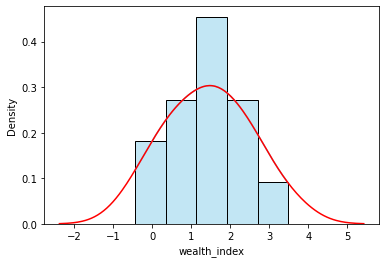

In [325]:
# Exemples DHS : Faire attention à ce que l'indice, construit aléatoirement existe réellement, 
# sinon on peut aussi retourner à la table dhs_stacked_wealth, sélécetionner l'année et voir les numéros de clusters correspondants

import random

id_dhs  = random.randint(1,10)
year = random.choice(years)
id_dhs = str(year) + '_' + str(id_dhs)
print(id_dhs)

cluster_wealth_distribution(dhs_wealth_stacked, id_dhs)

732
mean =  -1.380249, sd = 0.053666, q25 =  -1.402101, q75 =  -1.402101


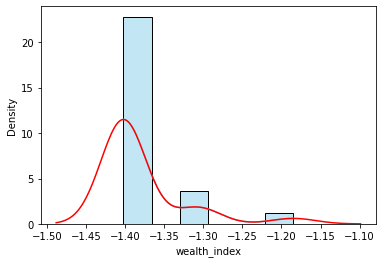

In [324]:
#Exemple MICS

id_mics = random.randint(1,800)
print(id_mics)

cluster_wealth_distribution(mics_wealth,id_mics)